In [12]:
import os
import cv2
import torch
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define Constant

In [13]:
FILE_PATH= "/kaggle/input/shop-lifter/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4" # Example to test functions
video_path = '/kaggle/input/shop-lifter/Shop DataSet'  # Path to your dataset
class_0 = "non shop lifters"
class_1 = "shop lifters"
out_path = "/kaggle/working/aug_vid"
if not os.path.exists(out_path):
    os.makedirs(out_path)
# Parameters
             # Number of frames to extract from each video
height, width = 90, 90        # Dimensions to resize each frame
channels = 3                  # Number of channels (RGB)
batch_size = 8          # Batch size for training
epochs = 30                   # Number of training epochs

### List all Videos with labels 

In [14]:
all_videos = []
for label, class_name in enumerate(os.listdir(video_path)):
    class_path = os.path.join(video_path, class_name)
    if os.path.isdir(class_path):
        for video_name in os.listdir(class_path):
            video_file = os.path.join(class_path, video_name)
            if video_file.endswith('.mp4'):  # Adjust for your video format
                all_videos.append((video_file, label))


print(f"Total videos: {len(all_videos)}")


Total videos: 855


In [15]:
all_videos [0]

('/kaggle/input/shop-lifter/Shop DataSet/non shop lifters/shop_lifter_n_216.mp4',
 0)

# Video Augmentation

In [16]:
import imgaug.augmenters as iaa

In [17]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import random

def augment_video(frames):
    """Apply a random combination of augmentations to video frames using albumentations."""
    
    # Define the individual augmentations
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),  # Flip with a 50% chance
        A.Rotate(limit=10, p=0.5),  # Randomly rotate between -10 and 10 degrees
        A.RandomCrop(width=20, height=20, p=0.5),  # Random crop
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Random brightness/contrast adjustment
    ])

    # Apply augmentations to each frame
    frames_aug = [transform(image=frame)['image'] for frame in frames]

    return frames_aug


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [18]:
# Split into training and testing sets
train_videos, test_videos = train_test_split(all_videos, test_size=0.2, stratify=[label for _, label in all_videos], random_state=42)

print(f"Total videos: {len(all_videos)}")
print(f"Training videos: {len(train_videos)}")
print(f"Testing videos: {len(test_videos)}")

Total videos: 855
Training videos: 684
Testing videos: 171


In [19]:
def count_frames(video_path):
    """Count the number of frames in a video file."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return 0
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count

In [20]:
def average_frames(video_dir):
    """Calculate the average number of frames for all videos in the specified directory."""
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    total_frames = 0
    video_count = 0
    
    for video_file in video_files:
        video_path = os.path.join(video_dir, video_file)
        frame_count = count_frames(video_path)
        if frame_count > 0:  # Ensure valid frame count
            total_frames += frame_count
            video_count += 1

    # Calculate average
    average = total_frames / video_count if video_count > 0 else 0
    return average


In [21]:
# Path to your dataset
avg_frames_0 = average_frames(os.path.join(video_path,class_0))
print(f"Average number of frames per video in class 0: {avg_frames_0:.2f}")

Average number of frames per video in class 0: 347.78


In [22]:
# Path to your dataset
avg_frames_1 = average_frames(os.path.join(video_path,class_1))
print(f"Average number of frames per video in class 1: {avg_frames_1:.2f}")

Average number of frames per video in class 1: 304.60


In [23]:
Total_frames_average  = (avg_frames_0  + avg_frames_1) //2
Total_frames_average

326.0

In [24]:
num_frames = int(Total_frames_average * .8 )
# num_frames = int(Total_frames_average)

In [25]:
class_names = []
video_counts = []
for label, class_name in enumerate(os.listdir(video_path)):
    class_path = os.path.join(video_path, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory (class folder)
        class_names.append(class_name)
        video_counts.append(len(os.listdir(class_path)))
        

In [26]:
label = []
for i, loops in enumerate(video_counts):
    for j in range(loops):
        label.append(i)
print(len(label))    

855


In [27]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label),
    y=label
)

# Convert to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict) 

{0: 0.8050847457627118, 1: 1.3194444444444444}


In [28]:
import datetime
def process_and_augment_videos(all_videos, out_path, num_frames=200, frame_step=15):
    for i in range(0, len(all_videos), frame_step):
        video, label = all_videos[i]
        
        if label == 1:
            frames = []
            cap = cv2.VideoCapture(video)
            
            if not cap.isOpened():
                print(f"Error opening video file {video}")
                continue

            frame_count = 0
            # Read frames from the video
            while cap.isOpened() and frame_count < num_frames:
                ret, frame = cap.read()
                if not ret:
                    break

                # Resize frame to fixed dimensions if needed
                frame = cv2.resize(frame, (width, height))
                
                # Append frame to the list
                frames.append(frame)
                frame_count += 1

            cap.release()

            # Convert list of frames to NumPy array for augmentation
            video_np = np.array(frames)
            
            # Perform augmentation
            augmented_frames = augment_video(video_np)

            # Save augmented video
            video_filename = f'{str(datetime.datetime.now())}.mp4'
            video_output_path = os.path.join(out_path, video_filename)

            # Define video writer with the same width and height as frames
            out = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))

            # Write augmented frames to the output video file
            for frame in augmented_frames:
                out.write(frame)

            out.release()

            # Append new video path and label to `all_videos`
            all_videos.append((video_output_path, label))

        

In [29]:
process_and_augment_videos(all_videos, out_path, num_frames=num_frames, frame_step=2)

In [30]:
print(f"Total videos: {len(all_videos)}")

Total videos: 1017


In [31]:
# Split into training and testing sets
train_videos, test_videos = train_test_split(all_videos, test_size=0.2, stratify=[label for _, label in all_videos], random_state=42)

print(f"Total videos: {len(all_videos)}")
print(f"Training videos: {len(train_videos)}")
print(f"Testing videos: {len(test_videos)}")


Total videos: 1017
Training videos: 813
Testing videos: 204


# Video generator

In [32]:
def video_generator(videos, batch_size, num_frames, height, width, channels, class_weights ):
    """Generator function to yield video batches with class weights from pre-defined video list."""
    while True:  # Loop indefinitely
        random.shuffle(videos)  # Shuffle the videos for each epoch

        data = []
        labels = []
        weights = []

        # Iterate through the shuffled list of videos
        for video_file, label in videos:
            frames = []
            cap = cv2.VideoCapture(video_file)

            if not cap.isOpened():
                print(f"Error opening video file {video_file}")
                continue

            frame_count = 0
            # Read frames from the video
            while cap.isOpened() and frame_count < num_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                # Resize frame and append to the frames list
                frame = cv2.resize(frame, (width, height))
                frame = frame.astype('float32') / 255.0
                frames.append(frame)
                frame_count += 1
            
            cap.release()

            # If the video has fewer frames than required, pad with zeros
            while len(frames) < num_frames:
                frames.append(np.zeros((height, width, channels), dtype=np.uint8))

            # Convert frames list to numpy array
            frames = np.array(frames)
          
            
            # Append the processed video, its label, and the corresponding weight
            data.append(frames)
            labels.append(label)
            
            
           
            #  weights.append(class_weights[label])  # Use class_weights

            # Yield batch of videos when data list reaches batch_size
            if len(data) == batch_size:
#                 yield np.array(data), np.array(labels), np.array(weights)
                yield np.array(data), np.array(labels)
                data = []  # Reset data list for the next batch
                labels = []  # Reset labels list for the next batch
#                 weights = []  # Reset weights list for the next batch

        # If there are leftover videos that don't fill a full batch, yield them
        if len(data) > 0:
#             yield np.array(data), np.array(labels), np.array(weights)
            yield np.array(data), np.array(labels)


In [33]:
# Create the generators
gen = video_generator(train_videos, batch_size, num_frames, height, width, channels, class_weights )
test_gen = video_generator(test_videos, batch_size, num_frames, height, width, channels, class_weights)


In [34]:
for batch in gen:
    videos , labels = batch
    print(videos.shape)
    print(labels)

    break

(8, 260, 90, 90, 3)
[0 1 0 1 0 0 0 1]


# Viualization

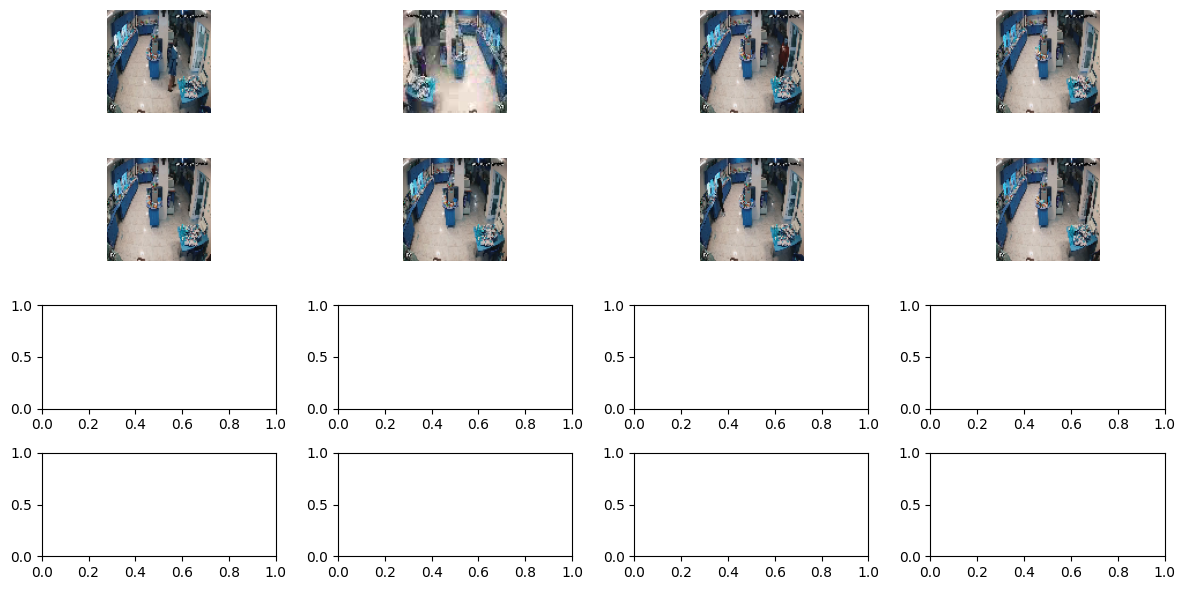

In [35]:
def plot_images(video_list):
    """Plot a list of 4 images in a 2x2 grid."""
    fig, axes = plt.subplots(2,4, figsize=(12, 6))  
    axes = axes.flatten()  
    
    for i, video in enumerate(video_list):
        axes[i].imshow(video[20,:,:,:] )
        axes[i].axis('off')  

    plt.tight_layout()
    plt.show()


plot_images(videos)



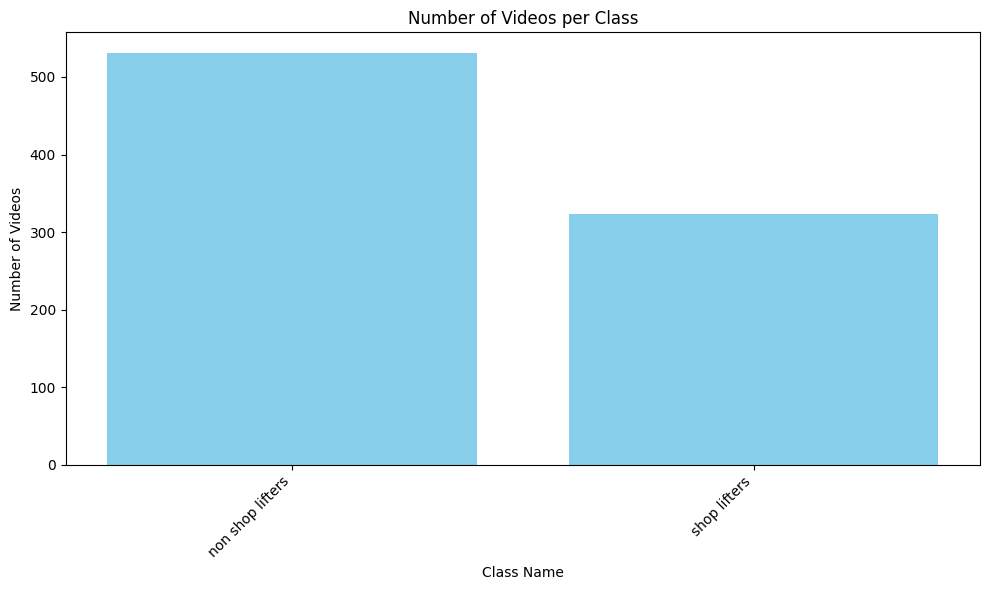

In [36]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(class_names, video_counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Videos')
plt.title('Number of Videos per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [37]:
all_videos[0]

('/kaggle/input/shop-lifter/Shop DataSet/non shop lifters/shop_lifter_n_216.mp4',
 0)

In [38]:
# Count the total number of videos in the list
total_videos = len(all_videos)
print("Total number of videos:", total_videos)

# Count the number of videos for each class
class_0_count = sum(1 for video in all_videos if video[1] == 0)
class_1_count = sum(1 for video in all_videos if video[1] == 1)

print("Number of class 0 videos:", class_0_count)
print("Number of class 1 videos:", class_1_count)

Total number of videos: 1017
Number of class 0 videos: 531
Number of class 1 videos: 486


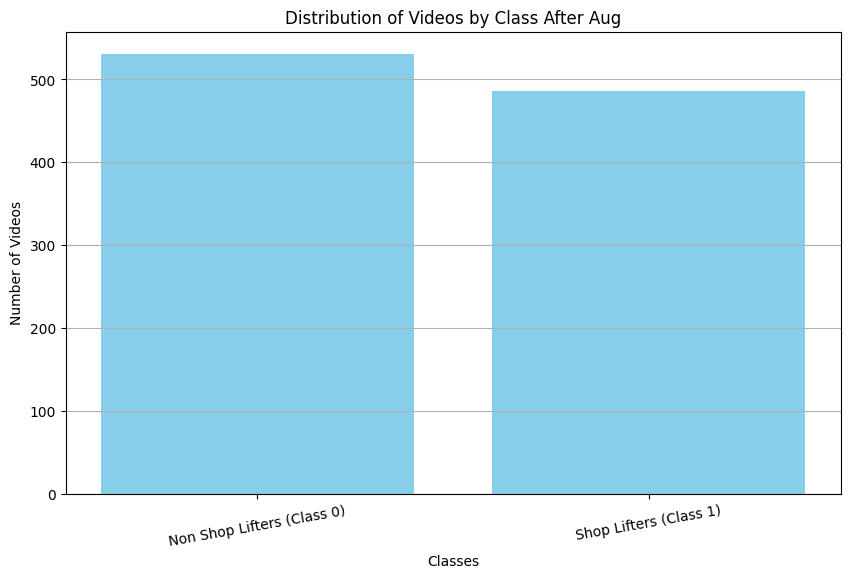

In [39]:
# Count the number of videos for each class
class_0_count = sum(1 for video in all_videos if video[1] == 0)
class_1_count = sum(1 for video in all_videos if video[1] == 1)


classes = ['Non Shop Lifters (Class 0)', 'Shop Lifters (Class 1)']
counts = [class_0_count, class_1_count]



plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Videos')
plt.title('Distribution of Videos by Class After Aug')
plt.xticks(rotation=10)
plt.grid(axis='y')
plt.show()

# 3DCNN Model

In [40]:
import tensorflow as tf

In [41]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [42]:
from tensorflow.keras import backend as K

# Clear the session to release memory
K.clear_session()

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [44]:

model = tf.keras.Sequential([
        tf.keras.layers.Conv3D(8, (3, 3, 3), activation='relu', input_shape=(num_frames, height, width, channels)),
        tf.keras.layers.MaxPooling3D((1, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv3D(16, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((1, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((1, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling3D(),
#         tf.keras.layers.Dense(128, activation='relu'), 
#         tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Dense(32, activation='relu'), 
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 258, 88, 88, 8) │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 258, 44, 44, 8) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 258, 44, 44, 8) │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 256, 42, 42,    │         3,472 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 256, 21, 21,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 21, 21,    │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 254, 19, 19,    │        13,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 254, 9, 9, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 254, 9, 9, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,330 (75.51 KB)

 Trainable params: 19,218 (75.07 KB)

 Non-trainable params: 112 (448.00 B)

In [47]:

steps_per_epoch = len(train_videos) // batch_size
validation_steps = len(test_videos) // batch_size

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('ShopLifter.keras',
    monitor='val_loss', 
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1)

callbacks = [early_stopping,lr_scheduler,checkpoint]

In [49]:
tf.get_logger().setLevel('ERROR')  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [50]:
#  Train the model
hist = model.fit(
                gen,
                steps_per_epoch=steps_per_epoch,
                epochs=15,
                validation_data=test_gen,
                validation_steps=validation_steps,
                batch_size=batch_size,
                callbacks = callbacks)

Epoch 1/15


I0000 00:00:1727447897.748950  120069 service.cc:145] XLA service 0x7f8304812120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727447897.749011  120069 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727447909.356091  120069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6145 - loss: 0.6523
Epoch 1: val_loss improved from inf to 0.69285, saving model to ShopLifter.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.6152 - loss: 0.6519 - val_accuracy: 0.5250 - val_loss: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7579 - loss: 0.5511
Epoch 2: val_loss did not improve from 0.69285
101/101 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7579 - loss: 0.5510 - val_accuracy: 0.5204 - val_loss: 0.8144 - learning_rate: 1.0000e-04
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7677 - loss: 0.5183
Epoch 3: val_loss did not improve from 0.69285
101/101 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.7679 - loss: 0.5182 - val_accuracy: 0.5306 - val_loss: 1.1490 - learning_rate: 1.0000e-04
Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7964 - loss: 0.4797
Epoch 4: val_loss did not improve from 0.69285
101/101 ━━━

# Evaluatation

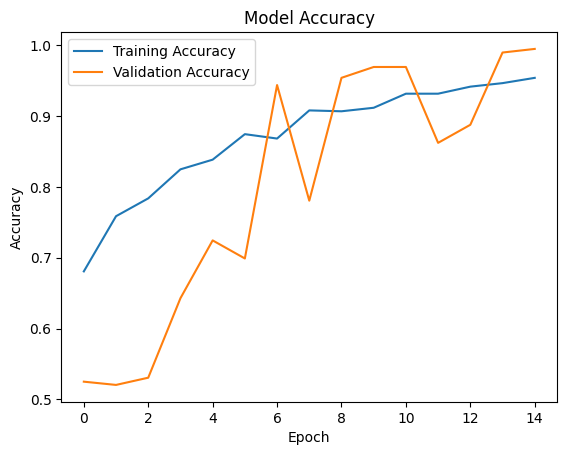

In [51]:
# Plot the accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

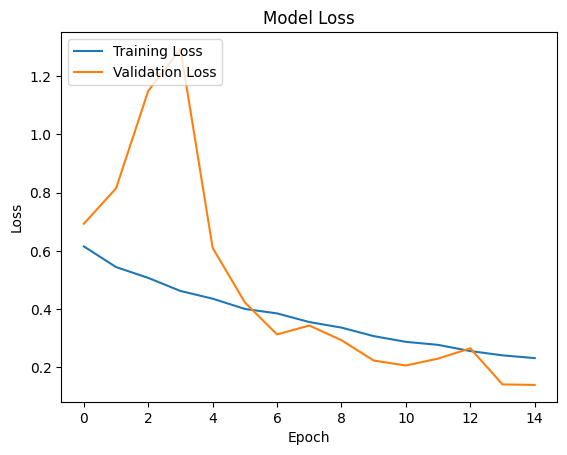

In [52]:
# Plot the loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 10)
plt.legend(loc='upper left')
plt.show()

In [53]:
# Save the model
model.save('shop_lifter_model.h5')

In [63]:
test_gen = video_generator(test_videos, batch_size, num_frames, height, width, channels, class_weights)


In [64]:
model = tf.keras.models.load_model("shop_lifter_model.h5")

In [65]:
loss, accuracy = model.evaluate(test_gen, steps=validation_steps)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9974 - loss: 0.1318
Loss: 0.13275350630283356
Accuracy: 0.9950000047683716


In [66]:
# Get the predicted class probabilities
y_pred = model.predict(test_gen, steps=validation_steps)

# Convert probabilities to class predictions (assuming binary classification)
y_pred_classes = np.argmax(y_pred, axis=1)



25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


In [87]:
test_videos[0]

('/kaggle/working/aug_vid/2024-09-27 14:37:44.684931.mp4', 1)

In [89]:
# Function to load video frames
test_gen = video_generator(test_videos, batch_size, num_frames, height, width, channels, class_weights)

# Parameters
num_frames = num_frames  
target_size = (width, height)  

# Prepare lists for true and predicted labels
results = []

# Loop through the test videos to evaluate
for video_frames, true_label in test_gen:
    if len(results) > 100:
        break
    if len(video_frames) == 0:
        continue  

    # Make predictions
    predictions = model.predict(video_frames)
    predicted_label = np.argmax(predictions, axis=1)  # Get the predicted classes for the batch

    # Store the true and predicted labels for each video in the batch
    for i in range(len(true_label)):
        results.append((true_label[i], predicted_label[i]))

# Convert results to a NumPy array for confusion matrix
results = np.array(results)

# Extract true and predicted labels separately
true_labels = results[:, 0]
predicted_labels = results[:, 1]




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


In [92]:
predicted_labels.shape

(104,)

In [93]:
true_labels.shape

(104,)

Confusion Matrix:
[[51  0]
 [ 0 53]]


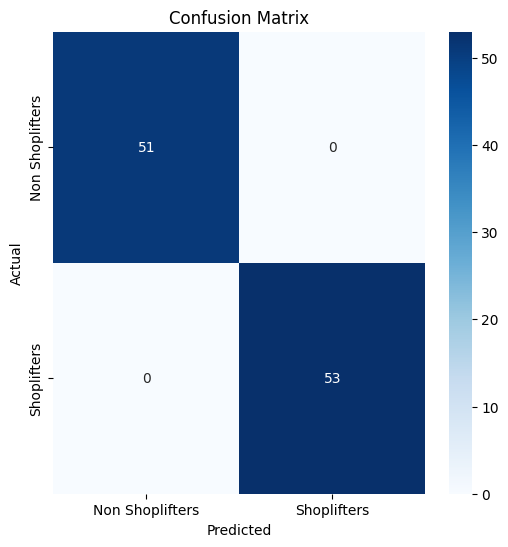

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix
# Optionally, generate a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Shoplifters', 'Shoplifters'], yticklabels=['Non Shoplifters', 'Shoplifters'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [95]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=['Non Shoplifters', 'Shoplifters'])
print(report)


                 precision    recall  f1-score   support

Non Shoplifters       1.00      1.00      1.00        51
    Shoplifters       1.00      1.00      1.00        53

       accuracy                           1.00       104
      macro avg       1.00      1.00      1.00       104
   weighted avg       1.00      1.00      1.00       104

